# Capture and Processing of Non-Destructive Data Streams
The output results of new non-destructive testing equipment needs to be analyzed over time to determine if process or equipment shifts occur. Process shifts will be detrimental to the company's ability to certify product, and may require additional rework. The project's focus will be on the development of the data-pipeline over the determination of process shifts. There are two major types of items that the inspection equipment will be reviewing. The first is production material. Detected flaws must be reacted to both upstream (fixing the cause) and downstream (responding to non-conforming product). The second type of item is a verification piece. The verification piece has known defects in the material which all need to be found, at approximately the same detection level every time the verification is run. 

The inspection equipment has controlling GUI. The GUI allows fro the review inspection results, but it is not an acceptable method to perform automatic reviews of the data. The GUI executable does expose a socket based API which allows for machine to machine data transfer. Some test result values are compiled by GUI, and can be retrieved. These results are not representative of all needed parameters which are important to the business operation e.g. (validating the inspection system is healthy). The raw stream data of the tests must also be extracted and processed for statistical characteristics. These characteristics will be tracked over time to look for process shifts. 

The raw data streams and interface have similarities to big data. The communications, analysis, data storage and tracking all need to be developed. These steps will include drawing from multiple data sources (TCP socket API, SQL), and publication of transformed data an SQL database in real time. Basic visualizations for determining process shifts should be included. 

# Required Data To Be Processed
A year ago, the NDT team determined what information will be necessary to capture on the verification rails either as a customer requirement or for process understanding. For the scope of this project, I will be focused on the calibration/verification data rather than product dat Below is a listing of those data.

INSERT PROCESS SIGNAL TABLE HERE

In [1]:
import pandas as pd
pd.read_csv('target_data_capture.csv')

,Equipment,KPI's to be measured/recorded,Olympus L2 Commands/Events,Data Source
0,Calibration,Calibration inspection number,Set Name (check cal and inspection),JSON/SQL
1,Calibration,Target identifier,Get Calibration Defect,JSON
2,Calibration,target location,Get Calibration Defect,JSON
3,Calibration,Found/Not found,Get Check Calibration Results or Verdict,JSON
4,Calibration,Primary probe used,Get Curve,JSON
5,Calibration,Signal amplitude,Get Check Calibration Results,JSON
6,Calibration,Expected response?,Get Check Calibration Results,JSON
7,Calibration,signal noise level,Get Curve,Stream
8,Calibration,Signal to Noise ratio,Get Curve,Stream
9,Calibration,Calibration rail number,Set Calibration Defect,JSON/SQL


# Configuring Test Equipment Database
The test database for the test equipment was provided by the vendor as a backup of a MS SQL server database, which was used during a factory acceptance test. It contains scans from verification material; flaws should be consistent. 

The database was version of the database was 15 (Server 2019). The only offline databases I had write permissions to was an earlier version, so I was unable to upload the newer version to it due to version incompatibility. 

I explored an alternate method of creating a Windows 10 virtual machine on my desktop and installing the latest version of SQL server express on it. Although it did work, the needed networking configuration to communicate with the other source databases was complicated by IT network policies.

After some additional research, I discovered MS SQL local database. After installing the SQL kernel, I was able to create a local only database which is suitable for small application development. The SQL database connection is exposed via a local host network pipe protocol. Once connected using the network pipe, the SQL server acts as if it was a full SQL server. This is an interesting alternative to a SQLite database for small applications. One of the more annoying aspects of using this method is that every instance of the database, once closed, changes its pipe path. 

I wrote a function in Python to run the windows executable and capture the STDOUT and extract the pipe path so it could be passed as the host for a connection string.

In [3]:
def start_local_test_db(db_name='EvidentTestDB'):
    """
    Starts local database instance if it isn't running yet
    db_name: str target database name
    Returns:
    host: str host pipe path for connection
    """
    import subprocess
    import re
    sqllocaldb = r"C:\Program Files\Microsoft SQL Server\160\Tools\Binn\SqlLocalDB.exe" 
    response = subprocess.run(
        [sqllocaldb,'info', db_name], 
        stdout=subprocess.PIPE
    )
    
    if "Stopped" in response.stdout.decode('utf-8'): # Start DB
        subprocess.run([sqllocaldb,'start', db_name])
        response = subprocess.run(
            [sqllocaldb,'info', db_name], 
            stdout=subprocess.PIPE
        )
    elif 'doesn\'t exist' in response.stdout.decode('utf-8'):
        raise ValueError(f'Database {db_name} doesn\'t exist.')
    return re.search(r'\\\\.\\pipe\\LOCALDB#........\\tsql\\query', response.stdout.decode('utf-8'))[0]
ndt_host = start_local_test_db()
ndt_host

'\\\\.\\pipe\\LOCALDB#35A98E3F\\tsql\\query'

## Establish Connection to Local Database
Because of the sensitive nature of connection strings to company servers which include passwords, I import connection strings from an external file. This file is saved locally, and will not get uploaded to the repository. 

I have three methods to connect to the database; two methods will provide raw data in tabular format e.g. using python/pandas/sqlalchemy or jupyter notebook sql direct connection . The API both receives and sends data in JSON format. Stream data is sent over a separate port. 

When connecting in any method, the connection string needs to be established.

In [4]:
import pandas as pd
from sqlalchemy import create_engine, text
from connections import get_tracking_connection_str, get_ndt_connection_str

# jupyter notebook extension to run in line sql using ipython-sql
%load_ext sql

ndt_connection_str = get_ndt_connection_str(host=ndt_host)

Establishing connection using `pandas`.

In [5]:
engine = create_engine(ndt_connection_str)
connection = engine.connect() #must close this at some point
output = pd.read_sql(text('SELECT * from Batch;'), connection)
connection.close()
output

,BatchIndex,OrderListNumber,Name,StartDate,EndDate,SteelType,Documents,Area,Thermal,FlowNumber,Customer,FK_B_OrderIndex,ProductDimension,ControlSpecification,OperatorName,Equipment,ProductPrefix
0,26,1,Test systeme,2022-03-28,2022-03-28,,,,,,,6,,,,,
1,27,2,Repetabilite,2022-03-28,2022-03-28,,,,,,,6,,,,,


Establishing connection using sql in-line

In [6]:
%sql $ndt_connection_str
%sql SELECT * from Batch;

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


BatchIndex,OrderListNumber,Name,StartDate,EndDate,SteelType,Documents,Area,Thermal,FlowNumber,Customer,FK_B_OrderIndex,ProductDimension,ControlSpecification,OperatorName,Equipment,ProductPrefix
26,1,Test systeme,2022-03-28 00:00:00,2022-03-28 00:00:00,,,,,,,6,,,,,
27,2,Repetabilite,2022-03-28 00:00:00,2022-03-28 00:00:00,,,,,,,6,,,,,


# API Interaction
The vendor provided a simple pyqt based GUI to demonstrate API connection protocols, and accessor functions. I dug through the source code to understand what components are necessary for communication. Taking these core components, I will have to create my own program which pulls requested data (in an non-GUI) format. 

At the core, ZeroMQ (`zmq`) is used for TCP socket communications. The vendor provided [ZMQClient](ZMQClient.py) classes which I will use for sending and receiving data. The API host is local on this machine, and as previously stated, uses different ports for different communication types. I need to establish the connection client objects using what was provided by the vendor. 

In [7]:
# Establish clients to connect to the API host
import ZMQClient
from globals import *

SYSTEM = 1

server_ip = '127.0.0.1'

client = ZMQClient.ZMQCommandClient(server_ip, 7600)
event_client = ZMQClient.ZMQEventClient(server_ip, 7601)
data_client= ZMQClient.ZMQDataClient(server_ip, 7602)

Objective 1: get calibration results/Defect file

In [57]:
channel_characteristics_ec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ChannelECIndex    160 non-null    int64  
 1   DataType          160 non-null    int64  
 2   Name              160 non-null    object 
 3   ChannelECID       160 non-null    int64  
 4   DataMin           160 non-null    float64
 5   DataMax           160 non-null    float64
 6   APD               160 non-null    int64  
 7   RPD               160 non-null    int64  
 8   AcquisitionRate   160 non-null    float64
 9   FK_C_ModeECIndex  160 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 12.6+ KB


In [64]:
# Channel characteristics
channel_characteristics_ut = %sql SELECT * FROM [dbo].[Channel];
channel_characteristics_ec = %sql SELECT * FROM [dbo].[ChannelEC];

channel_characteristics_ut = pd.DataFrame(channel_characteristics_ut)
channel_characteristics_ec = pd.DataFrame(channel_characteristics_ec)

channel_names = pd.concat([
    channel_characteristics_ut[['ChannelID', 'Name']].drop_duplicates(),
    (
        channel_characteristics_ec
        [['ChannelECID', 'Name']]
        .drop_duplicates()
        .rename(columns={'ChannelECID': 'ChannelID'})
    )],
    axis=0,
    keys=['UT', 'EC']
).droplevel(-1).set_index('ChannelID', append=True)
channel_names

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.
 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


Name
   ChannelID          
UT 0              H1-1
   1000             H1
   11            B2:ST
   8           W2:ST-3
   5             W1:ST
   2                H2
   10            B1:BR
   7           W2:ST-2
   4            HS2:ST
   1              H1-2
   1001          W2:ST
   9           W2:ST-4
   6           W2:ST-1
   3            HS1:BR
EC 1          CHRS1:LT
   2          CHRS1:OB
   3          CHRB1:LT
   4          CHRB1:OB
   5           SHS1:LT
   6           SHS1:OB
   7           SHB1:LT
   8           SHB1:OB
   11          IFS1:LT
   12          IFS1:OB
   13          FES1:LT
   14          FES1:OB
   15           BS1:LT
   16           BS1:OB
   19          IFB1:LT
   20          IFB1:OB
   21          FEB1:LT
   22          FEB1:OB
   23           BB1:LT
   24           BB1:OB

In [8]:
# GetProductListByType
products = {}
for key, value in TECHNOLOGY.items():
    if isinstance(key, str):
        json_response = client.sendCommand(
            'get_product_list_by_type', {
                'type': value
            }
        )
        products[key] = json_response['product_types']
products

{'UT': ['ris_115_Rail 115 ProveUp',
  'ris_136-ALT-4_Rail 136 ProveUp',
  'ris_141-ALT_Rail 141 ProveUp',
  'ris_141-ALT_test web',
  'ris_141-ALT_Rail 141 Test sonde mono',
  'ris_141-ALT_Rail 141 ProveUp Perpendicular',
  'ris_141-ALT_test web Perpendicular',
  'ris_141-ALT_Rail 141 Test master gauge',
  'ris_141-ALT_Rail 141 Test uni QV',
  'ris_141-ALT'],
 'EC': ['ris_115_Rail 115 Prove Up',
  'ris_115_Rail 115 Test EC',
  'ris_115_Rail 115 Test EC 25 PSI',
  'ris_115_Rail 115 Prove Up Inverse',
  'ris_115_Rail 115 Test silent bloc',
  'ris_115_Rail 115 ProveUp',
  'ris_136-ALT-4_Rail 136 ProveUp',
  'ris_136-ALT-4_Rail 136 ProveUp Nouveau Patin EC',
  'ris_136-ALT-4_Rail 136 ProveUp Nouveau Patin EC Base modifie',
  'ris_141-ALT_Rail 141 ProveUp',
  'ris_141-ALT_Rail 141 ProveUp 15Psi',
  'ris_141-ALT']}

In [108]:
# Get Order List
def get_order_list():
    json_response = client.sendCommand(
        'get_order_list', {
        }
    )
    return json_response['orders']

order = get_order_list()[0]
order

'RAIL 136 PROVE UP FINAL'

In [10]:
# Get Batch List
def get_batch_list(order):
    json_response = client.sendCommand(
        'get_batch_list', {
            'order': order
        }
    )
    return json_response['batches']

batches = get_batch_list(order)
batches

['Test systeme', 'Repetabilite']

In [11]:
# Get Batch Info
def get_batch_info(order, batch):
    json_response = client.sendCommand(
        'get_batch_info', {
            'order': order,
            'batch': batch
        }
    )
    return json_response['batch_info']
get_batch_info(order, batches[0])

{'area': '',
 'batch_id': 26,
 'control_specification': '',
 'customer_name': '',
 'default_setup_ec': 'Evraz EC Prove Up_ris_136-ALT-4_Rail 136 ProveUp.set',
 'default_setup_ec_id': 9,
 'default_setup_ut': 'Evraz UT Prove Up_ris_136-ALT-4_Rail 136 ProveUp_0_2.acq',
 'default_setup_ut_id': 17,
 'end_date': '3/10/2023',
 'file_number': '',
 'grade': '',
 'heat': '',
 'nuance_of_steel': '',
 'operator_name': '',
 'product_dimension': '',
 'product_type_ec': 'ris_136-ALT-4_Rail 136 ProveUp',
 'product_type_ec_id': 8,
 'product_type_ut': 'ris_136-ALT-4_Rail 136 ProveUp',
 'product_type_ut_id': 4,
 'start_date': '3/28/2022'}

In [12]:
# Get Tube List
def get_rail_list(order, batch, check_calibration=False):
    json_response = client.sendCommand(
        'get_tube_list', {
            'order': order,
            'batch': batch,
            'check_calibration': check_calibration
        }
    )
    return json_response['tubes']
rail_list = get_rail_list(order, batches[0])
print(f"Number of rails in batch '{batches[0]}': {len(rail_list)}")
rail_list[:2]

Number of rails in batch 'Test systeme': 45


[{'db_index': 2366,
  'inspection_date': '6/1/2022 1:36:10 PM',
  'judgement': 2,
  'length': 6734249,
  'name': 'Rail 1',
  'order_list_number': 1,
  'scan_number': 1,
  'start': 0},
 {'db_index': 2367,
  'inspection_date': '6/1/2022 1:37:17 PM',
  'judgement': 2,
  'length': 6722800,
  'name': 'Rail 2',
  'order_list_number': 2,
  'scan_number': 1,
  'start': 0}]

In [31]:
# Get Curve
def get_curves(
        rail_index,
        channel=-1,
        gate=0,
        data=0,
        mode=0,
        group=0,
        check_cal=False,
):
    json_response =  client.sendCommand(
        'get_curve', {
            'system_id': SYSTEM,
            'tube_id' : rail_index,
            'channel_id': channel,
            'mode_id' : mode,
            'group_type' : group,
            'gate_id' : gate,
            'data_type': data,
            'check_calibration': check_cal
            }
        )
    for curve in json_response['curves']:
        curve['descriptor']['rail_index'] = curve['descriptor'].pop('tube_id')
        curve['stream']['rail_index'] = curve['stream'].pop('tube_id')
    return json_response['curves']

display_order = [ # set display order
    'system_id',
    'rail_index',
    #'ec',
    'mode',
    'group',
    'data_type',
    'gate_id',
    'channel_id',
    'channel_name',
    'data_min',
    'data_max',
    'data_qty',
    'index_qty',
    'index_res',
    'index_start_offset',
    'index_first_valid_point',
    'scan_qty',
    'scan_res',
    'inspection_direction',
    'product_length',
    'orientation',
]

def curves_to_frame(curves):
    descriptor = []
    stream = []
    for curve in curves:
        descriptor.append(curve['descriptor'])
        stream.append(curve['stream'])
    descriptor_df = pd.DataFrame.from_dict(descriptor)
    descriptor_df = (
        descriptor_df
        .assign(
            mode=descriptor_df['mode_id'].map(MODE),
            group=descriptor_df['group_type'].map(GROUP_TYPE),
        )
        .replace({
            'inspection_direction': INSPECTION_DIRECTION,
            'orientation': ORIENTATION,
            'data_type': DATA_TYPE
        }
        )
        .rename(columns={
            #'tube_id': 'rail_index',
            'name': 'channel_name'
            })
        [display_order]
    )
    stream_df = pd.DataFrame.from_dict(stream)
    return (
        pd.concat(
            [descriptor_df, stream_df],
            axis=1,
            keys=['Descriptor', 'Stream']
        )
    )

curve_df = curves_to_frame(get_curves(2366))
curve_df['Stream'].head()

,data_size,length,stream_id,system_id,rail_index
0,1,2693,0,1,2366
1,1,2693,1,1,2366
2,1,19240,2,1,2366
3,1,19240,3,1,2366
4,1,14965,4,1,2366


<AxesSubplot: >

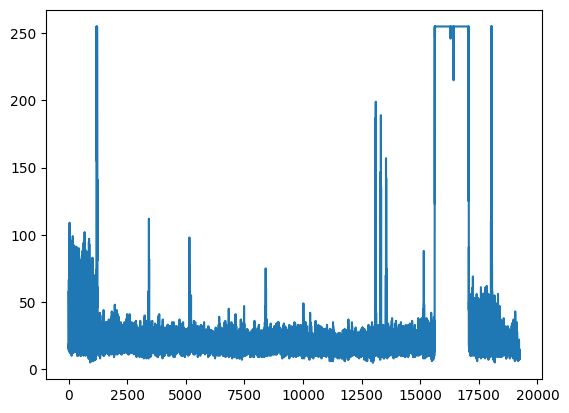

In [41]:
# Get Streams
def get_stream(
        rail_index,
        stream_id,
        length,
        data_size,
        data_position=0,
        system_id=SYSTEM,
        **kwargs
):
    json_response =  client.sendCommand(
        'get_stream', {
            'streams': [{
                'system_id': system_id,
                'tube_id': rail_index,
                'stream_id': stream_id,
                'length': length,
                'data_size' : data_size,
                'data_position': data_position,
            }]
        }
    )
    if json_response['streams'][0]['status']:
        stream_data = data_client.receiveData()
        return list(bytearray(stream_data))
    else:
        raise TypeError(f'Retrieval of stream_id {stream_id} failed.')

stream = pd.Series(get_stream(**get_curves(2366)[3]['stream']))
stream.plot();

Defect Determination
1D Ultrasonic

In [70]:
# Get Defects 1D UT
def get_defects_1d_ut(
        rail_index,
        system_id=SYSTEM,
        merge_type=0,
        merge_gates=False,
        **kwargs
):
    if (merge_type in range(1, 4)) and merge_gates:
        raise ValueError('Merge Gates only compatible with merge type `Global`(0)')

    json_response =  client.sendCommand(
        'get_defects_ut', {
            'tube_id': rail_index,
            'system_id': system_id,
            'merge_type': merge_type,
            'merge_gates': merge_gates,
        }
    )
    return json_response['defects']

def defects_1d_ut_to_frame(defects):
    return (
        pd.DataFrame(defects)
        .join(channel_names.loc['UT'], on='channel_id')
        .rename(columns={'Name': 'channel_name'})
    )

defect_1d_ut_df = defects_1d_ut_to_frame(get_defects_1d_ut(2366))
print(defect_1d_ut_df.info())
defect_1d_ut_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   alarm_id         433 non-null    int64  
 1   axial_length     433 non-null    float64
 2   axial_position   433 non-null    float64
 3   channel_id       433 non-null    int64  
 4   gate_id          433 non-null    int64  
 5   group_id         433 non-null    int64  
 6   mode_id          433 non-null    int64  
 7   radial_length    433 non-null    float64
 8   radial_position  433 non-null    float64
 9   submode_id       433 non-null    int64  
 10  channel_name     433 non-null    object 
dtypes: float64(4), int64(6), object(1)
memory usage: 37.3+ KB
None


,alarm_id,axial_length,axial_position,channel_id,gate_id,group_id,mode_id,radial_length,radial_position,submode_id,channel_name
0,1,5.6,11.200,3,1,0,11,0.0,0.0,1,HS1:BR
1,1,2.8,238.000,3,1,0,11,0.0,0.0,1,HS1:BR
2,1,2.8,282.800,4,1,0,11,0.0,0.0,2,HS2:ST
3,1,7.5,367.500,2,2,0,10,0.0,0.0,0,H2
4,1,9.6,374.399,1000,1,0,10,0.0,0.0,0,H1


In [73]:
# Get Defects 2D UT
def get_defects_2d_ut(
        rail_index,
        **kwargs
):
    json_response =  client.sendCommand(
        'get_defects_2d_ut', {
            'tube_id': rail_index,
        }
    )
    return json_response['defects']

def defects_2d_ut_to_frame(defects):
    return (
        pd.DataFrame(defects)
        .join(channel_names.loc['UT'], on='channel_id')
        .rename(columns={'Name': 'channel_name'})
    )
get_defects_2d_ut(2366)
#defect_2d_ut_df = defects_2d_ut_to_frame(get_defects_2d_ut(2366))
#print(defect_2d_ut_df.info())Santa Fe, New Mexico
#defect_2d_ut_df.head()

[]

In [100]:
# Get Defects 2D EC
def get_defects_2d_ec(
        rail_index,
        **kwargs
):
    json_response =  client.sendCommand(
        'get_defects_2d_ec', {
            'tube_id': rail_index,
        }
    )
    return json_response['defects']

def defects_2d_ec_to_frame(defects):
    return (
        pd.DataFrame(defects)
        .drop(columns='coords')
        .join(channel_names.loc['EC'], on='channel_id')
        .replace({'data_type': DATA_TYPE}
        )
        .rename(columns={'Name': 'channel_name'})
    )

def defects_2d_coordinates(defects):
    idx = ['bottom left', 'top left', 'top right', 'bottom right']
    df_l = [pd.DataFrame(defect['coords'], index=idx) for defect in defects]
    return pd.concat(df_l, keys=range(len(defects)))

#def defects
defect_2d_ec_df = defects_2d_ec_to_frame(get_defects_2d_ec(2366))
print(defect_2d_ec_df.info())
defect_2d_ec_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alarm_id      345 non-null    int64  
 1   amplitude     345 non-null    float64
 2   channel_id    345 non-null    int64  
 3   data_type     345 non-null    object 
 4   group_id      345 non-null    int64  
 5   channel_name  345 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 16.3+ KB
None


,alarm_id,amplitude,channel_id,data_type,group_id,channel_name
0,1,-2.36,1,All,1,CHRS1:LT
1,1,4.14,1,All,1,CHRS1:LT
2,1,2.78,1,All,1,CHRS1:LT
3,1,-2.01,1,All,1,CHRS1:LT
4,1,-5.00,1,All,1,CHRS1:LT


In [99]:
defects_2d_coordinates(get_defects_2d_ec(2366)).head(10)

x     y
0 bottom left   437.0  60.0
  top left      437.0  64.0
  top right     440.0  64.0
  bottom right  440.0  60.0
1 bottom left   441.0  64.0
  top left      441.0  68.0
  top right     446.0  68.0
  bottom right  446.0  64.0
2 bottom left   442.0  55.0
  top left      442.0  59.0

In [130]:
# Get calibration defects, currently not operational in API
#def get_setup_calibration_defects_ut(
#    calibration_product,
#    setup_id,
#    system_id=0,
#):
#    json_response = client.sendCommand(
#        'get_setup_calibration_defects_ut', {
#            'system_id': system_id,
#            'calibration_product': calibration_product,
#            'setup_id': setup_id
#        }
#    )
#    return json_response['defects']
#
#cal_defects = get_setup_calibration_defects_ut('Rail 136 Prove Up', 27)
#cal_defects

# Processing Signal to Noise ratio


In [129]:
def stream_stats(stream):
    if isinstance(stream, list):
        stream = pd.Series(stream)
    threshold = 0.8 * stream.max()
    signal_pts = stream.where(stream > threshold)
    noise_pts = stream.where(stream < threshold)

    signal_lvl = pd.Series(signal_pts.mean(), index=['Signal'])
    noise_lvl = pd.Series(noise_pts.median(), index=['Noise'])
    signal_noise = pd.Series(signal_lvl.loc['Signal'] / noise_lvl.loc['Noise'], index=['SNR'])
    
    return pd.concat([signal_lvl, noise_lvl, signal_noise])

stream_stats(stream)


Signal    254.802770
Noise      20.000000
SNR        12.740139
dtype: float64

254.8027704485488

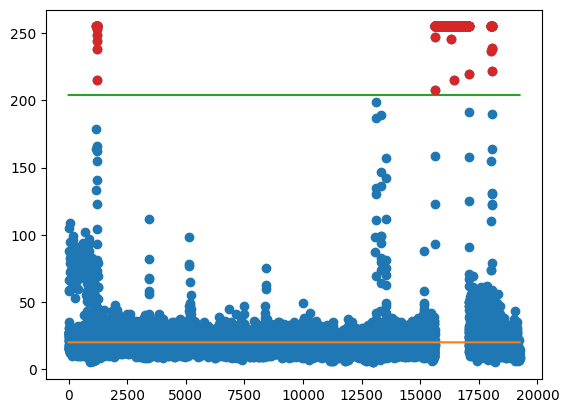

In [122]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)

threshold = .8 * max(stream)
signal = stream.where(stream> threshold)
noise = stream.where(stream<threshold)

stream.plot(ax=ax, style='o')
pd.Series(noise.median(), index=stream.index).plot(ax=ax)
pd.Series(threshold, index=stream.index).plot(ax=ax)
signal.plot(ax=ax, style='o')


# Database Schema
I want to explore the database schema for this local database to identify relevant data. These are the available tables. There are 110 tables in this database. I want to determine a quick way of seeing how they are linked to each other, and rely as much as possible on the API to get as much information as I can. 

In [7]:
# Print table characteristics in database
%sql SELECT * FROM INFORMATION_SCHEMA.TABLES ORDER BY TABLE_NAME;

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#3731EEAB\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
EvrazL2Test,dbo,AlarmFilter,BASE TABLE
EvrazL2Test,dbo,AlarmFilterSetup,BASE TABLE
EvrazL2Test,dbo,AlarmInfoEC,BASE TABLE
EvrazL2Test,dbo,AppSetting,BASE TABLE
EvrazL2Test,dbo,Batch,BASE TABLE
EvrazL2Test,dbo,BatchCustomFieldTemplate,BASE TABLE
EvrazL2Test,dbo,BatchCustomFieldValue,BASE TABLE
EvrazL2Test,dbo,BatchEC,BASE TABLE
EvrazL2Test,dbo,BatchUT,BASE TABLE
EvrazL2Test,dbo,BenchInfo,BASE TABLE


I do have the script needed to look at individual table schemas, if necessary. Picking one simple table, `Batch` is used to create groupings of test results.

In [9]:
%%sql
SELECT schema_name(tab.schema_id) AS schema_name,
    tab.name as table_name, 
    col.column_id,
    col.name as column_name, 
    t.name as data_type,
    col.max_length,
    col.precision
FROM sys.tables as tab
    INNER JOIN sys.columns as col
        on tab.object_id = col.object_id
    LEFT JOIN sys.types as t
    on col.user_type_id = t.user_type_id
WHERE tab.name like 'Batch'
ORDER BY schema_name, table_name, column_id;

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#3731EEAB\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


schema_name,table_name,column_id,column_name,data_type,max_length,precision
dbo,Batch,1,BatchIndex,int,4,10
dbo,Batch,2,OrderListNumber,int,4,10
dbo,Batch,3,Name,nvarchar,200,0
dbo,Batch,4,StartDate,datetime,8,23
dbo,Batch,5,EndDate,datetime,8,23
dbo,Batch,6,SteelType,nvarchar,100,0
dbo,Batch,7,Documents,nvarchar,100,0
dbo,Batch,8,Area,nvarchar,100,0
dbo,Batch,9,Thermal,nvarchar,100,0
dbo,Batch,10,FlowNumber,nvarchar,100,0


Looking at the values of the `Batch` table.


Getting SQL in ipython
https://www.sqlshack.com/learn-jupyter-notebooks-for-sql-server/


# Configuring NDT Database

In [13]:
sql = '''--begin-sql
SELECT schema_name(tab.schema_id) AS schema_name,
    tab.name as table_name, 
    col.column_id,
    col.name as column_name, 
    t.name as data_type,
    col.max_length,
    col.precision
FROM sys.tables as tab
    INNER JOIN sys.columns as col
        on tab.object_id = col.object_id
    LEFT JOIN sys.types as t
    on col.user_type_id = t.user_type_id
ORDER BY schema_name, table_name, column_id;
--end-sql
'''
engine = create_engine(ndt_connection_str)
connection = engine.connect() #must close this at some point
table_schema = pd.read_sql(text(sql), connection)
connection.close()
table_schema

,schema_name,table_name,column_id,column_name,data_type,max_length,precision
0,dbo,AlarmFilter,1,AlarmFilterIndex,int,4,10
1,dbo,AlarmFilter,2,APDFilter,int,4,10
2,dbo,AlarmFilter,3,RPDFilter,int,4,10
3,dbo,AlarmFilter,4,FK_AF_ModeIndex,int,4,10
4,dbo,AlarmFilter,5,GateID,tinyint,1,3
...,...,...,...,...,...,...,...
1081,dbo,WTRAlarm,6,WTRemaining,int,4,10
1082,dbo,WTRAlarm,7,WTValue,int,4,10
1083,dbo,WTRAlarm,8,DefectDepth,int,4,10
1084,dbo,WTRAlarm,9,EntryDate,datetime,8,23


I found an online database diagraming software, dbdiagram.io. They allow for using simple syntax to build database diagrams. Below is the code that formats 95% of the table structures. The remaining 5% is done by hand, dealing with some naming convention inaccuracies. Final script is at [data diagram](dbdiagram_all.txt). There are nearly 110 tables and 1100 columns in the database. Going through the whole diagram is difficult, but visualizing some of the relationships could be important. The most useful part of this exercise is understanding the vendor's table and index name scheme. Their foreign keys are FK_\<abbreviation of current db\>_<connectedDB\>Index.

In [32]:
with open('dbdiagram_raw.txt', 'w') as f:
    for table_name, df in table_schema.groupby('table_name'):
        f.write('Table %s {\n' % table_name)
        for row in df.itertuples(index=False, name='Field'):
            if row.column_name.startswith('FK'):
                ref_col = row.column_name.split('_')[-1]
                ref_table = ref_col[:-5]
                ref = f"[ref: > {ref_table}.{ref_col}]"
            else: 
                ref=''
            f.write(f'  {row.column_name} {row.data_type} {ref}\n')
        f.write('}\n\n')

When built the auto generated database diagram is extensive. 

![ERD](dbdiagram_all.png)

I will try to use the API as much as possible to get the desired data. Eventually I'm sure i will need to revisit the schema.

NDT API incorporation

# action plan
extract data which would be present in L2
Load to L2
Pull back down from L2
Query stream data
Run analysis

In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import matplotlib as mpl
#import seaborn as sns
#from IPython.display import display_html

#from bokeh.plotting import figure, show, output_file
#from bokeh.models import ColumnDataSource
#output_file('file.html')


# place %sql #CONNECTION to connect
# place %%sql at start to run sql block
# $ for python variable
